# Baseline testing

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import _testing

In [ ]:
## Constant
RANDOM_STATE = 0

## Data preparation

In [ ]:
## Read csv file
df = pd.read_csv('train_all_tasks.csv')

### train/dev/test split

In [ ]:
# text and labels for task A
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(df['text'], df['label_sexist'], test_size=0.3, random_state=RANDOM_STATE)
X_test_a, X_dev_a, y_test_a, y_dev_a = train_test_split(X_test_a, y_test_a, test_size=0.33, random_state=RANDOM_STATE)

# text and labels for task B
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(df[df['label_sexist'] == 'sexist']['text'],
                                                               df[df['label_sexist'] == 'sexist']['label_category'],
                                                               test_size=0.3,
                                                               random_state=RANDOM_STATE)
X_test_b, X_dev_b, y_test_b, y_dev_b = train_test_split(X_test_b, y_test_b, test_size=0.33, random_state=RANDOM_STATE)

In [ ]:
## Printing the label distribution for Task A and B
print(Counter(y_train_a))
print(Counter(y_dev_a))
print(Counter(y_test_a))
print("")
print(Counter(y_train_b))
print(Counter(y_dev_b))
print(Counter(y_test_b))

Counter({'not sexist': 7413, 'sexist': 2387})
Counter({'not sexist': 1058, 'sexist': 328})
Counter({'not sexist': 2131, 'sexist': 683})

Counter({'2. derogation': 1107, '3. animosity': 812, '1. threats, plans to harm and incitement': 231, '4. prejudiced discussions': 228})
Counter({'2. derogation': 157, '3. animosity': 115, '4. prejudiced discussions': 37, '1. threats, plans to harm and incitement': 28})
Counter({'2. derogation': 326, '3. animosity': 238, '4. prejudiced discussions': 68, '1. threats, plans to harm and incitement': 51})


### Output formatting

In [ ]:
def confmatrix_display(confmatrix, model_name, task_name):
    """This function takes an sklearn confusion matrix to generate a graphical plot, which is
    customized to fit the current task."""
    plt.rcParams.update({'font.size': 12})
    plt.figure(dpi=1200)

    if task_name == 'taskA':
        labels = df['label_sexist'].unique() 
    else:
        labels = df[df['label_sexist'] == 'sexist']['label_category'].sort_values().unique()
        labels[0] = '1. threats...'

    cm_display = ConfusionMatrixDisplay(confmatrix, display_labels=labels).plot()
    # cm_display = ConfusionMatrixDisplay(confmatrix).plot()
    
    if task_name != 'taskA':
        plt.xticks(rotation=45, ha='right')

In [ ]:
def report(model_name, ydev, pred, task_name, zero_division=1):
    """This function takes the model name, prediction, and gold standard, 
    and prints a formatted report and confusion matrix based on this data."""
    conf_matrix = confusion_matrix(ydev, pred)
    print("\n=== {0} ===\n\nClassification Report:\n{1}"
          "\nConfusion Matrix:\n{2}".format(model_name,
                                            classification_report(ydev, pred, 
                                                                  zero_division=zero_division),
                                            confusion_matrix(ydev, pred)))

    confmatrix_display(conf_matrix, model_name, task_name)

### Model setup

In [ ]:
@_testing.ignore_warnings(category=ConvergenceWarning)
def logistic_regression(xtrain, ytrain, xdev, ydev, le, task_name):
  """This function trains a Logistic Regression model and predicts the labels on a test set, 
  which it prints the classification report and confusion matrix for by calling the report function."""
  model_name = "logistic regression"
  model = LogisticRegression(random_state=RANDOM_STATE)
  vec = CountVectorizer()

  vec.fit(xtrain, xdev)
  xtrain_enc = vec.transform(xtrain)
  xdev_enc = vec.transform(xdev)

  model.fit(xtrain_enc, ytrain)
  pred = model.predict(xdev_enc)
  pred = le.inverse_transform(pred)

  report(model_name, ydev, pred, task_name)

## Task A (Binary) - Logistic regression

In [ ]:
task_name = 'taskA'
le = LabelEncoder()

le.fit(y_train_a)
y_train_a = le.transform(y_train_a)


=== logistic regression ===

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.85      0.94      0.89      2131
      sexist       0.72      0.48      0.58       683

    accuracy                           0.83      2814
   macro avg       0.78      0.71      0.74      2814
weighted avg       0.82      0.83      0.82      2814

Confusion Matrix:
[[2001  130]
 [ 352  331]]


<Figure size 7200x4800 with 0 Axes>

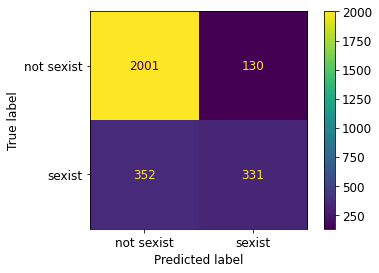

In [ ]:
logistic_regression(X_train_a, y_train_a, X_test_a, y_test_a, le, task_name)

## Task B (Multi-class) - Logistic regression

In [ ]:
task_name = 'taskB'

le.fit(y_train_b)
y_train_b = le.transform(y_train_b)


=== logistic regression ===

Classification Report:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.52      0.43      0.47        51
                           2. derogation       0.57      0.64      0.60       326
                            3. animosity       0.46      0.46      0.46       238
               4. prejudiced discussions       0.32      0.18      0.23        68

                                accuracy                           0.52       683
                               macro avg       0.47      0.43      0.44       683
                            weighted avg       0.50      0.52      0.51       683

Confusion Matrix:
[[ 22   9  15   5]
 [ 12 208  97   9]
 [  5 111 110  12]
 [  3  37  16  12]]


<Figure size 7200x4800 with 0 Axes>

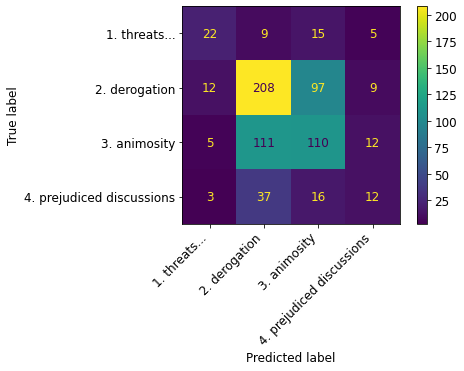

In [ ]:
logistic_regression(X_train_b, y_train_b, X_test_b, y_test_b, le, task_name)